# Essai des modèles de clustering

## Importation des bibliothèques nécessaires

In [20]:
# Manipulation des données
import pandas as pd
import numpy as np
# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement des données
from sklearn.preprocessing import  MinMaxScaler

# Réduction de dimension
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE
from umap import UMAP

from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import warnings 
warnings.simplefilter(action='ignore', category=Warning)

# afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

sns.set_style("whitegrid")


## Chargement des données

In [21]:
# chargement du fichier
customers_rfm = pd.read_csv('RFM.csv')
print(customers_rfm)

                     customer_unique_id  Montant_total  Nbre Produit  Poids Produit  Paulistanos order_purchase_timestamp  Fréquence  Score   Catégorie Produit  Récence  Panier Moyen
0      0000366f3b9a7992bf8c76cfdf3221e2         129.90           1.0         1500.0            1      2018-05-10 10:56:27          1    5.0     cama_mesa_banho      160        129.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f          18.90           1.0          375.0            1      2018-05-07 11:11:27          1    4.0        beleza_saude      163         18.90
2      0000f46a3911fa3c0805444483337064          69.00           1.0         1500.0            0      2017-03-10 21:05:03          1    3.0           papelaria      585         69.00
3      0000f6ccb0745a6a4b88665a16c9f078          25.99           1.0          150.0            0      2017-10-12 20:29:41          1    4.0           telefonia      369         25.99
4      0004aac84e0df4da2b147fca70cf8255         180.00           1.0         6050.0  

## Data Preprocessing & Feature Engineering

### Analyse Exploratoire

In [22]:
# fonction qui renvoie la liste des variables par type
def grab_col_names(dataframe):
    # cat_cols: nominal, binary, ordinal
    # num_cols: interval, discrete
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    cat_cols_binaires = [col for col in dataframe.columns if dataframe[col].dtypes == "O"
                                and dataframe[col].nunique() == 2]
    return cat_cols, num_cols , cat_cols_binaires

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(customers_rfm)
print(cat_cols)
print(num_cols)
print(cat_but_car)

['customer_unique_id', 'order_purchase_timestamp', 'Catégorie Produit']
['Montant_total', 'Nbre Produit', 'Poids Produit', 'Paulistanos', 'Fréquence', 'Score', 'Récence', 'Panier Moyen']
[]


<Axes: >

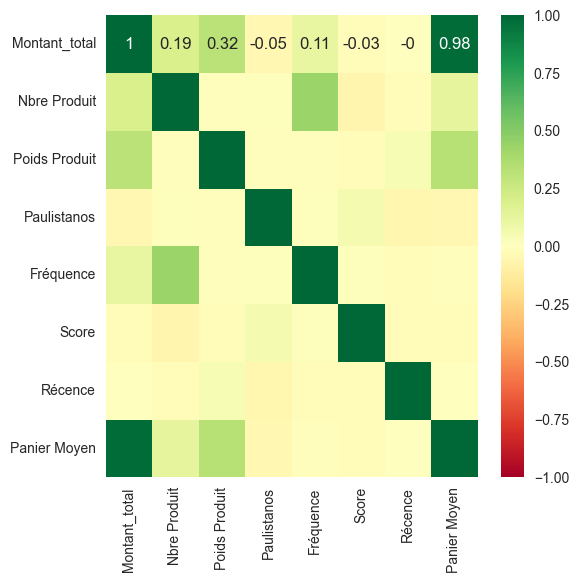

In [24]:
# corrélation entre les variables numériques
plt.figure(figsize=(6, 6))
sns.heatmap(customers_rfm[num_cols].corr().round(2), annot=True, cmap='RdYlGn', center=0, vmin=-1, vmax=1)

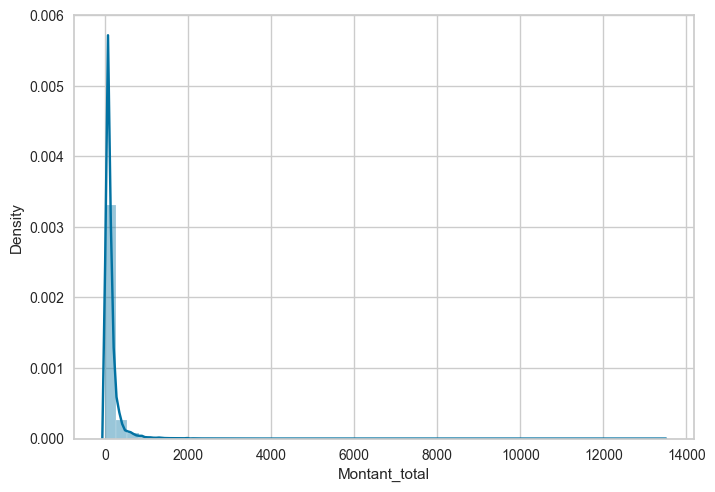

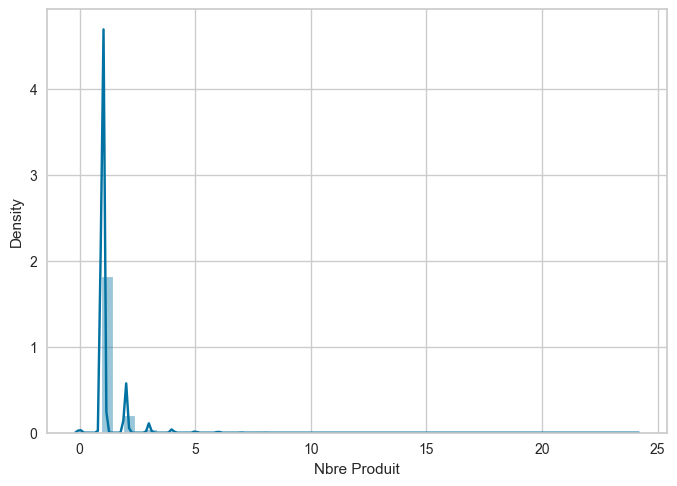

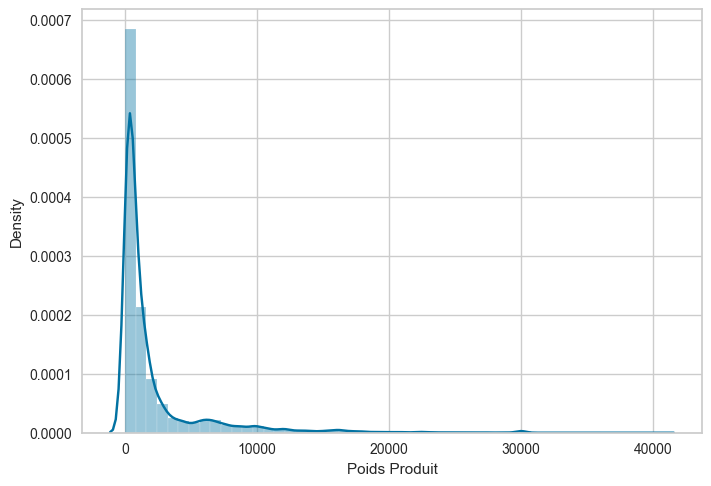

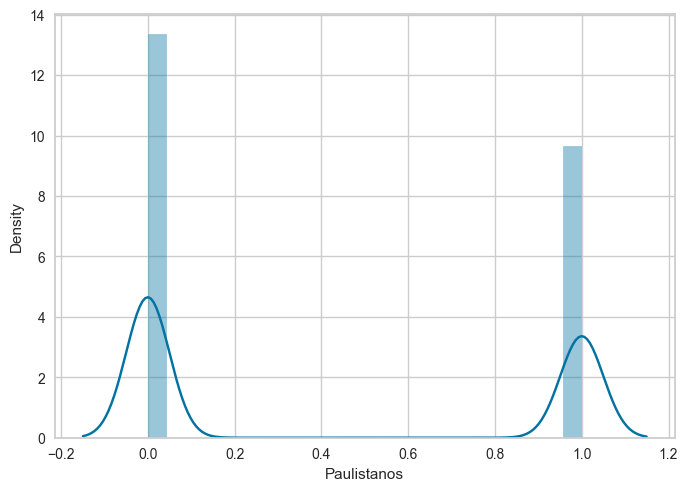

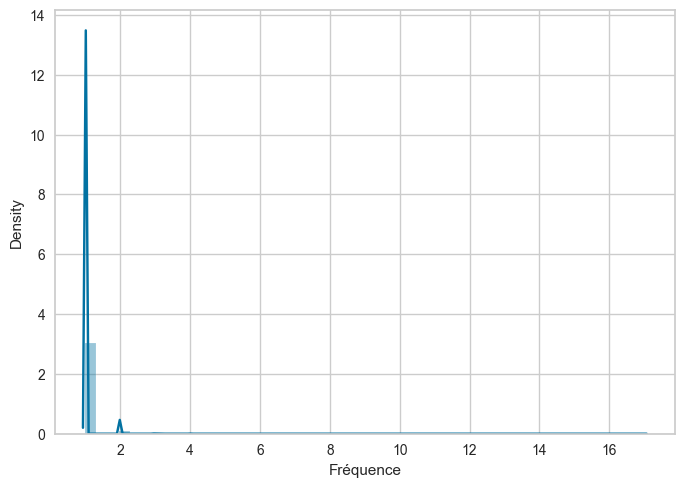

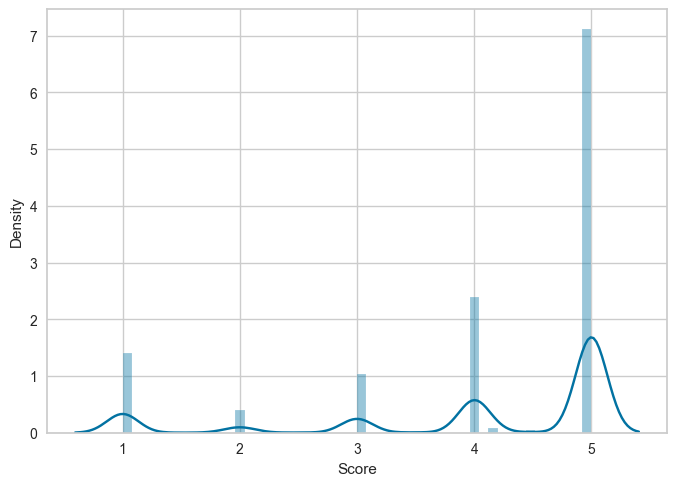

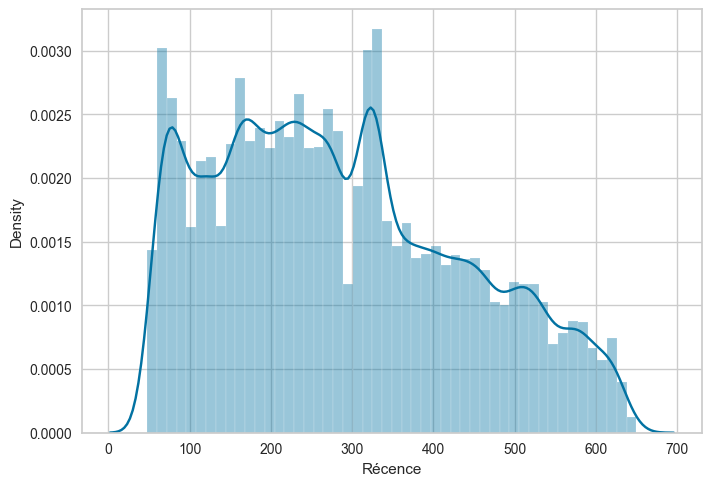

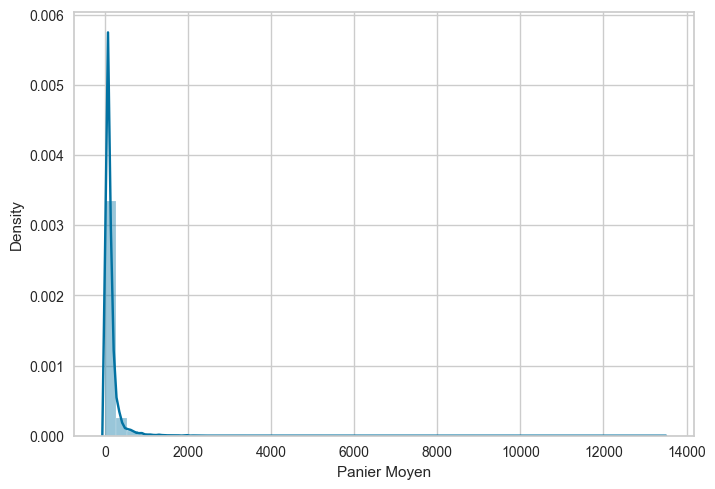

In [25]:
# distribution des variables numériques
for col in num_cols:
    sns.distplot(customers_rfm[col])
    plt.show()

### Outlier

In [26]:
outlier_rfm = customers_rfm.copy()

In [27]:
# drop nbre de produits
outlier_rfm.drop('Nbre Produit', axis=1, inplace=True)
outlier_rfm.drop('Panier Moyen', axis=1, inplace=True)
outlier_rfm.drop('Paulistanos', axis=1, inplace=True)
cat_cols, num_cols, cat_but_car = grab_col_names(outlier_rfm)

In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [29]:

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [30]:
outlier_thresholds(outlier_rfm,num_cols)

(Montant_total    -115.99625
 Poids Produit   -1987.50000
 Fréquence           1.00000
 Score               2.50000
 Récence          -185.00000
 dtype: float64,
 Montant_total     315.99375
 Poids Produit    4072.50000
 Fréquence           1.00000
 Score               6.50000
 Récence           743.00000
 dtype: float64)

In [31]:
cols_to_remplace = ['Poids Produit',"Montant_total"]

for col in cols_to_remplace:
    replace_with_thresholds(outlier_rfm, col)

In [32]:
print(outlier_rfm)

                     customer_unique_id  Montant_total  Poids Produit order_purchase_timestamp  Fréquence  Score   Catégorie Produit  Récence
0      0000366f3b9a7992bf8c76cfdf3221e2      129.90000         1500.0      2018-05-10 10:56:27          1    5.0     cama_mesa_banho      160
1      0000b849f77a49e4a4ce2b2a4ca5be3f       18.90000          375.0      2018-05-07 11:11:27          1    4.0        beleza_saude      163
2      0000f46a3911fa3c0805444483337064       69.00000         1500.0      2017-03-10 21:05:03          1    3.0           papelaria      585
3      0000f6ccb0745a6a4b88665a16c9f078       25.99000          150.0      2017-10-12 20:29:41          1    4.0           telefonia      369
4      0004aac84e0df4da2b147fca70cf8255      180.00000         4072.5      2017-11-14 19:45:42          1    5.0           telefonia      336
...                                 ...            ...            ...                      ...        ...    ...                 ...      ...
95757 

### MinMaxScaler

In [33]:
# Séparer les colonnes numériques et non numériques
num_cols = outlier_rfm.select_dtypes(include=['number']).columns
non_num_cols = outlier_rfm.select_dtypes(exclude=['number']).columns

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(outlier_rfm[num_cols])
X = pd.DataFrame(X, columns=num_cols)
X

,Montant_total,Poids Produit,Fréquence,Score,Récence
0,0.411084,0.368324,0.0,1.00,0.186047
1,0.059811,0.092081,0.0,0.75,0.191030
2,0.218359,0.368324,0.0,0.50,0.892027
3,0.082248,0.036832,0.0,0.75,0.533223
4,0.569632,1.000000,0.0,1.00,0.478405
...,...,...,...,...,...
95757,1.000000,1.000000,0.0,1.00,0.742525
95758,0.205352,0.422345,0.0,0.75,0.435216
95759,0.284499,0.147330,0.0,1.00,0.945183
95760,0.363931,0.109024,0.0,1.00,0.199336


In [35]:
sample_data = X.sample(n=10000, random_state=42)

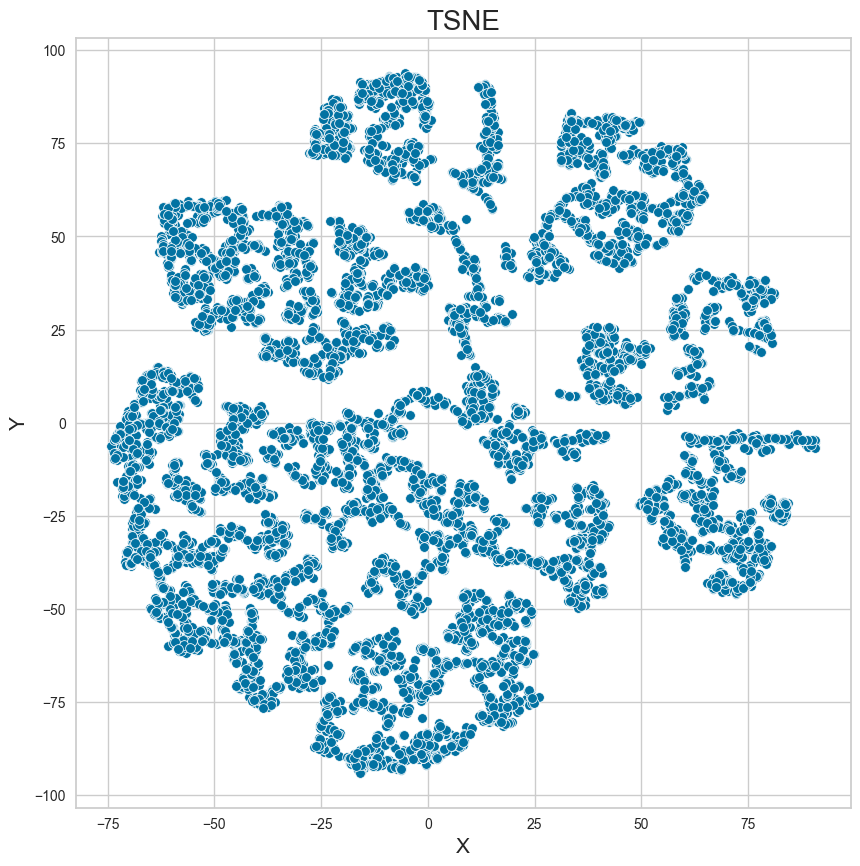

In [36]:
# visualisation des données avec TSNE
tsne = TSNE(random_state=42)
tsne_results = tsne.fit_transform(sample_data)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1])
plt.title('TSNE', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.show()


## K-Means

### Elbow Method

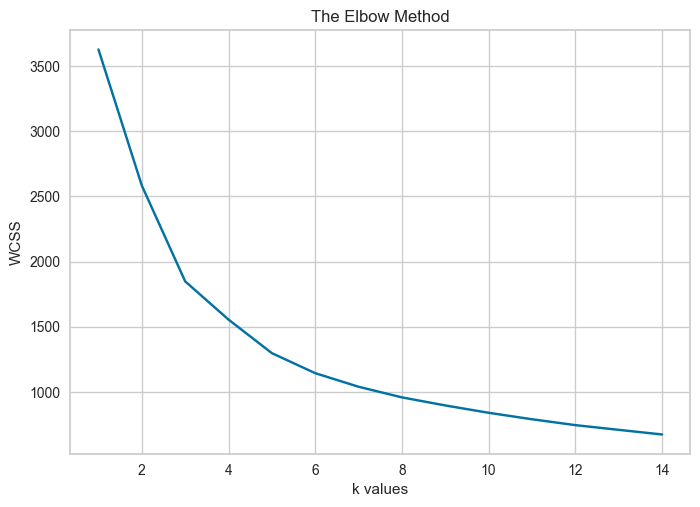

In [37]:
wcss = []  # We created a list to hold WCSS values.
for k in range(1, 15):  # We looped the numbers from 1 to 15.
    kmeans = KMeans(n_clusters=k).fit(sample_data[num_cols])  # We ran the K-Means algorithm.
    wcss.append(kmeans.inertia_)  # We added the WCSS values to the wcss list.

plt.plot(range(1, 15), wcss, 'bx-')  # We plotted the WCSS values.
plt.xlabel('k values')
plt.ylabel('WCSS')  
plt.title('The Elbow Method')  
plt.show()

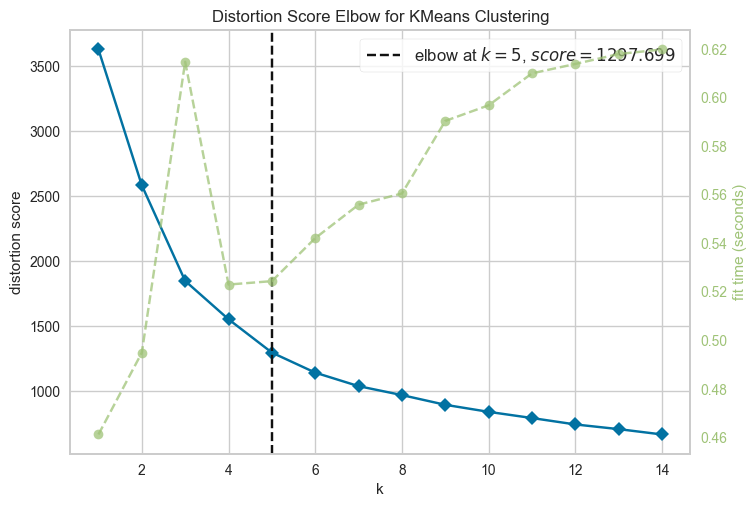

5

In [38]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(1, 15))
elbow.fit(sample_data[num_cols])
elbow.show(block=True)

elbow.elbow_value_

In [39]:
kmeans = KMeans(n_clusters=elbow.elbow_value_, init='k-means++').fit(sample_data[num_cols])
params=kmeans.get_params()
params

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 5,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [40]:
# score de silhouette
from sklearn.metrics import silhouette_score
silhouette_score(sample_data[num_cols], kmeans.labels_)

0.3104611890409558

### Visualisation des clusters avec TSNE

In [41]:
if 'cluster' in sample_data.columns:
    sample_data.drop('cluster', axis=1, inplace=True)
    

# kmeans avec seulement 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++').fit(sample_data[num_cols])
clusters_kmeans = kmeans.labels_    # Indicates which observation the clusters belong to.
sample_data["cluster"] = clusters_kmeans   # We added a variable named cluster_no to X.

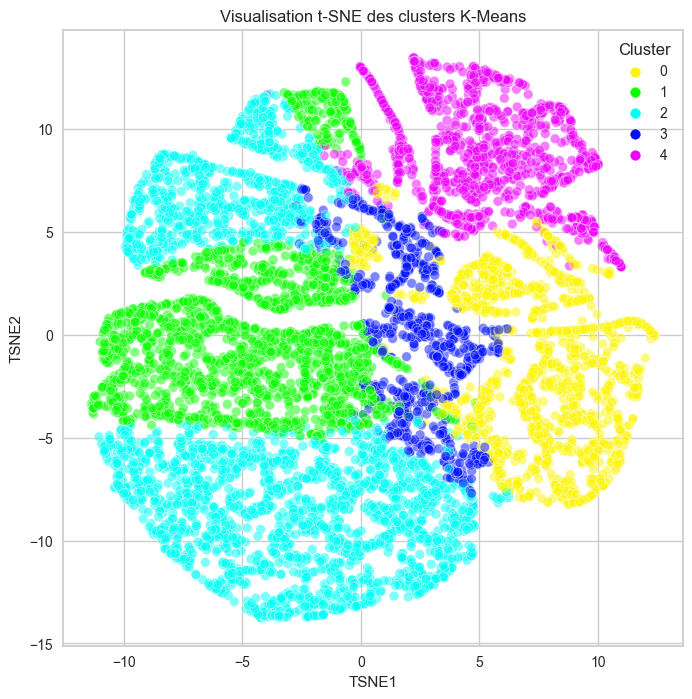

In [42]:
# Appliquer t-SNE sur les données normalisées et étiquetées
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(sample_data[num_cols].values)
# Visualisation avec Seaborn
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = sample_data['cluster'].values
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="Cluster",
    palette=sns.color_palette("hsv", len(set(sample_data['cluster']))),
    data=df_tsne,
    legend="full",
    alpha=0.5
)
plt.title('Visualisation t-SNE des clusters K-Means')
plt.show()


0.31044627463277885


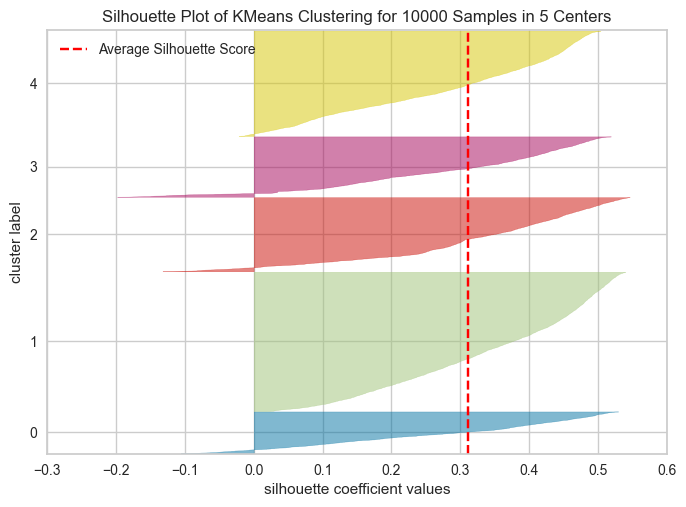

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
# score de silhouette
parameters=kmeans.get_params() 
# Entraînement du modèle KMeans
kmeans = KMeans(**parameters)
kmeans.fit(sample_data[num_cols])

# Calcul du score de silhouette
score = silhouette_score(sample_data[num_cols], kmeans.labels_)
print(score)
parameters = kmeans.get_params()

# Instantiate the clustering model and visualizer

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(sample_data[num_cols])        # Fit the training data to the visualizer
visualizer.show()        # Finalize and render the figure

## Clustering DBSCAN

In [44]:
# sauvegarder de X dans un fichier csv
#X.to_csv('Xdbscan_test.csv', index=False)
X = pd.read_csv('Xdbscan_test.csv')

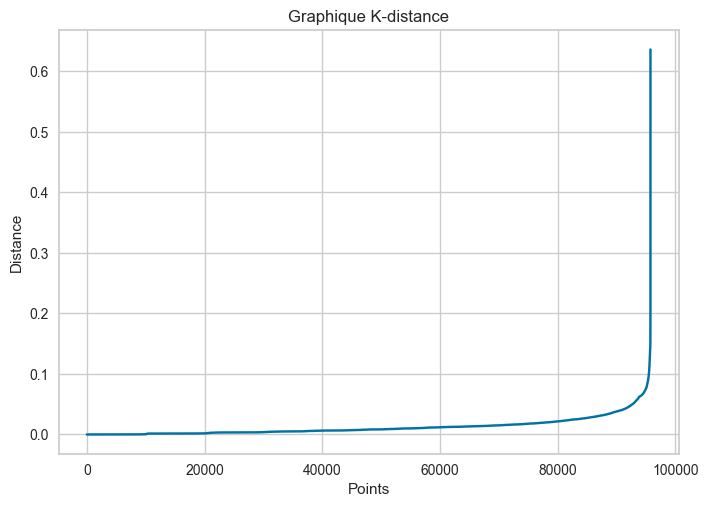

In [45]:
#sample_data=X.sample(10000, random_state=42)
cat_cols,num_cols,  cat_but_car = grab_col_names(X)

if 'cluster' in X.columns:
    X.drop('cluster', axis=1, inplace=True)
    
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X[num_cols])
distances, indices = neighbors_fit.kneighbors(X[num_cols])

# Trier les distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('Graphique K-distance')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.show()


In [46]:
# EPS et min_samples doivent être choisis en fonction de la densité de vos données
db = DBSCAN(eps=0.5, min_samples=10000)  # Ajustez eps basé sur votre graphique K-distance
cluster_labels = db.fit_predict(X[num_cols])

# Nombre de clusters dans les labels, en ignorant le bruit si présent.
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

print('Nombre estimé de clusters: %d' % n_clusters_)
print('Nombre estimé de points de bruit: %d' % n_noise_)

# calculer le score de silhouette comme précédemment, 
#if n_clusters_ > 1:
    #silhouette_avg = silhouette_score(X, cluster_labels)
    #print('Le score de silhouette moyen est :', silhouette_avg)

Nombre estimé de clusters: 1
Nombre estimé de points de bruit: 3527


In [48]:
X["cluster"] = cluster_labels

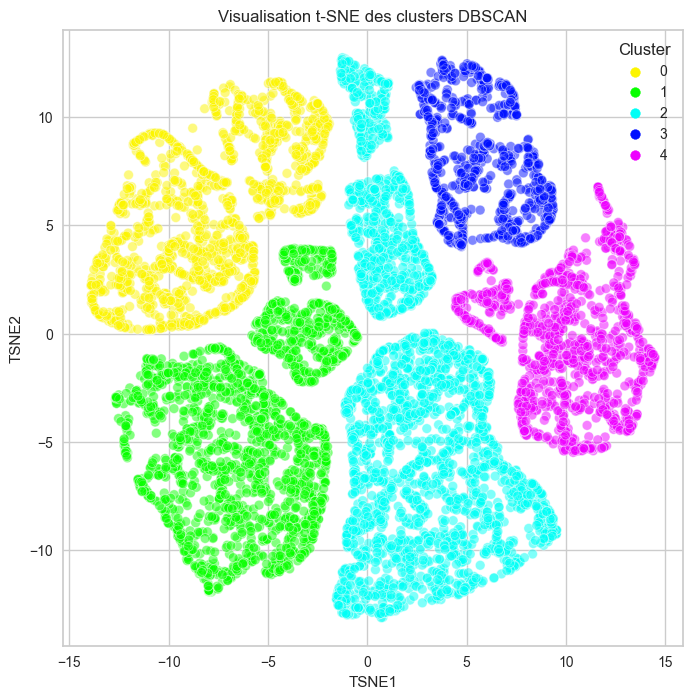

In [49]:
cat_cols,num_cols,  cat_but_car = grab_col_names(sample_data)

# Appliquer t-SNE sur les données normalisées et étiquetées
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(sample_data[num_cols].values)
# Visualisation avec Seaborn
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = sample_data['cluster'].values
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="Cluster",
    palette=sns.color_palette("hsv", len(set(sample_data['cluster']))),
    data=df_tsne,
    legend="full",
    alpha=0.5
)
plt.title('Visualisation t-SNE des clusters DBSCAN')
plt.show()


## Clustering Hiérarchique

In [50]:
sample_data2 = X.sample(n=1000, random_state=42)
if 'cluster' in sample_data2.columns:
    sample_data2.drop('cluster', axis=1, inplace=True)

linkage_matrix = linkage(sample_data2, method='ward')

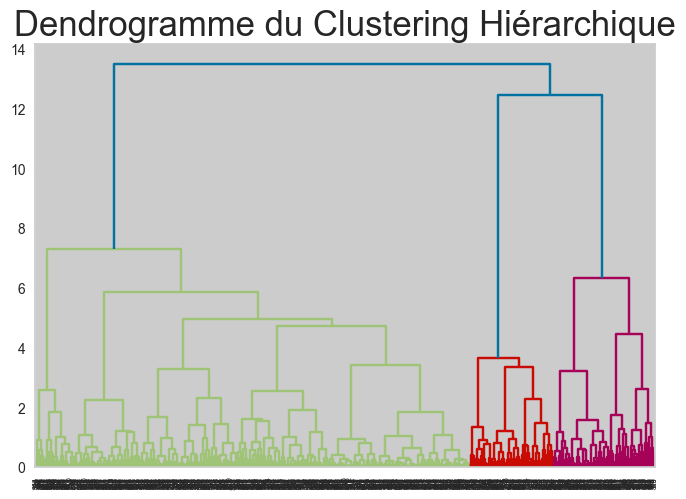

<Figure size 1500x1500 with 0 Axes>

In [51]:

# Create the dendrogram
dend = dendrogram(linkage_matrix)
plt.title('Dendrogramme du Clustering Hiérarchique', fontsize=25)
plt.figure(figsize=(15,15))
# Show the dendrogram
plt.show()

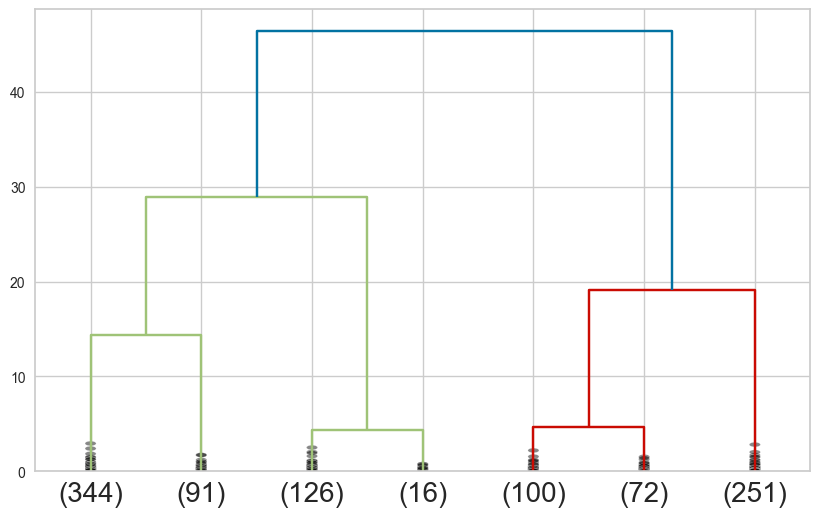

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# échantillon de données plus petit pour le dendrogramme
sample_data2 = sample_data.sample(n=1000, random_state=42)
# Lien hiérarchique utilisant la méthode de 'ward'
linked = linkage(sample_data2, 'ward')

# Visualisation avec un dendrogramme
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending',
           truncate_mode="lastp",
           p=7,
           show_contracted=True,
           leaf_font_size=10)
plt.title('')
plt.xticks(fontsize=20)
plt.show()

# Choix d'un nombre de clusters basé sur le dendrogramme (par exemple 5)
ac = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
cluster_labels = ac.fit_predict(sample_data2)


In [53]:
hc = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
clusters_hc = hc.fit_predict(sample_data2)

In [54]:
# score de silhouette
print(silhouette_score(sample_data2, clusters_hc))

0.575973855270916


## Exploration des 4 clusters K-means

In [55]:
if 'cluster' in X.columns:
    X.drop('cluster', axis=1, inplace=True)
    
kmeans = KMeans(n_clusters=5, init='k-means++').fit(X)

X["cluster"] = kmeans.labels_
customers_rfm["cluster"] = kmeans.labels_


In [56]:

# Renommer les clusters
customers_rfm['cluster'] = customers_rfm['cluster'].map({0:'Standards 2017', 1:'Piliers',2:'Mécontents', 3:'Standards 2018', 4:'Premiums'})




In [57]:
# sauvegarder le fichier
#customers_rfm.to_csv('RFM_cluster_clusters.csv')
#customers_rfm = pd.read_csv('RFM_cluster_clusters.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'RFM_cluster_clusters.csv'

In [ ]:

# remplacer le nom de catégorie Mécontents par Insatisfaits
customers_rfm['cluster'] = customers_rfm['cluster'].replace('Mécontants', 'Mécontents')

In [ ]:
# plot des variables numériques par cluster
cat_cols_stat, num_cols_stat, cat_ca_stat = grab_col_names(customers_rfm)
print(num_cols_stat)
print(cat_cols_stat)
print(cat_ca_stat)

['Unnamed: 0', 'Montant_total', 'Nbre Produit', 'Poids Produit', 'Paulistanos', 'Fréquence', 'Score', 'Récence', 'Panier Moyen']
['customer_unique_id', 'order_purchase_timestamp', 'Catégorie Produit', 'cluster']
[]


In [ ]:

#for col in num_cols_stat:
#    sns.boxplot(x='cluster', y=col, data=customers_rfm)
#    plt.show()
#    

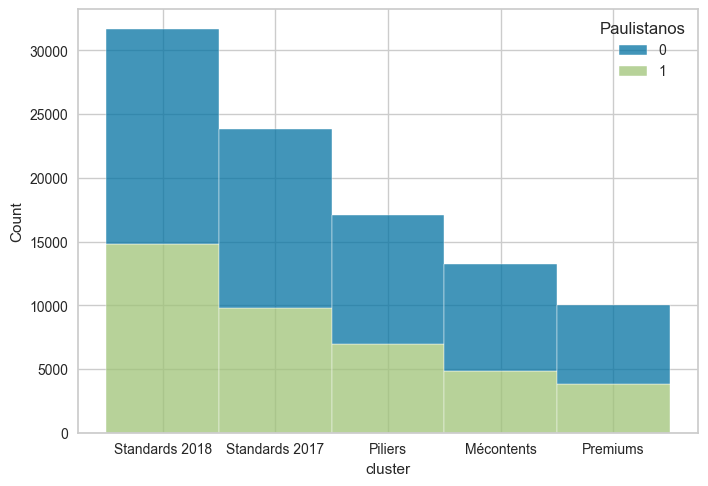

In [ ]:
# Graphique à barres empilées
sns.histplot(data=customers_rfm, x='cluster', hue='Paulistanos', multiple='stack')

# Afficher le graphique
plt.show()    

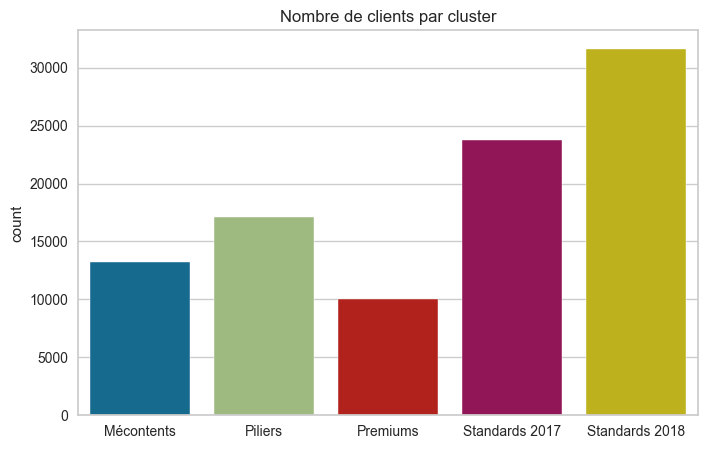

                  cluster
cluster                  
Mécontents      13.787306
Piliers         17.852593
Premiums        10.462396
Standards 2017  24.848061
Standards 2018  33.049644


In [ ]:
plt.figure(figsize=(8, 5))
# Définir l'ordre des clusters
cluster_order = customers_rfm['cluster'].value_counts().index.sort_values()

sns.countplot(x='cluster', data=customers_rfm, order=cluster_order)
plt.title('Nombre de clients par cluster')
plt.xlabel('') 
plt.show()

print(customers_rfm.groupby('cluster').agg({'cluster': 'count'})/customers_rfm.shape[0]*100)


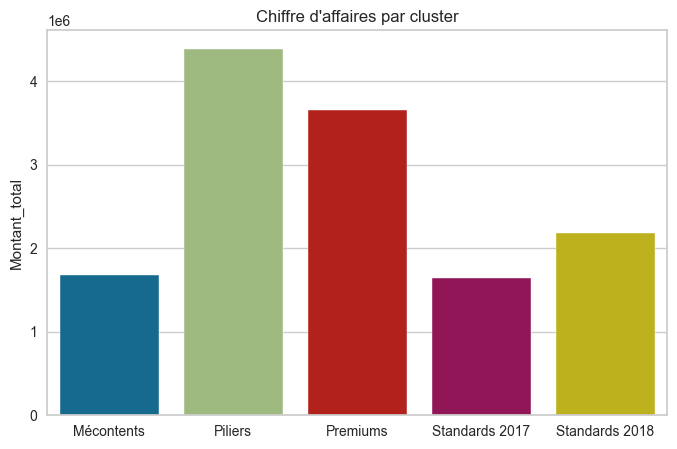

                Montant_total
cluster                      
Mécontents          12.358096
Piliers             32.402860
Premiums            27.012175
Standards 2017      12.154869
Standards 2018      16.072000


In [ ]:

# par du chiffee d'affaire en bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=customers_rfm.groupby('cluster')['Montant_total'].sum().index, y=customers_rfm.groupby('cluster')['Montant_total'].sum())
plt.title('Chiffre d\'affaires par cluster')
plt.xlabel('') 
plt.show()

print(customers_rfm.groupby('cluster').agg({'Montant_total': 'sum'})/customers_rfm['Montant_total'].sum()*100)

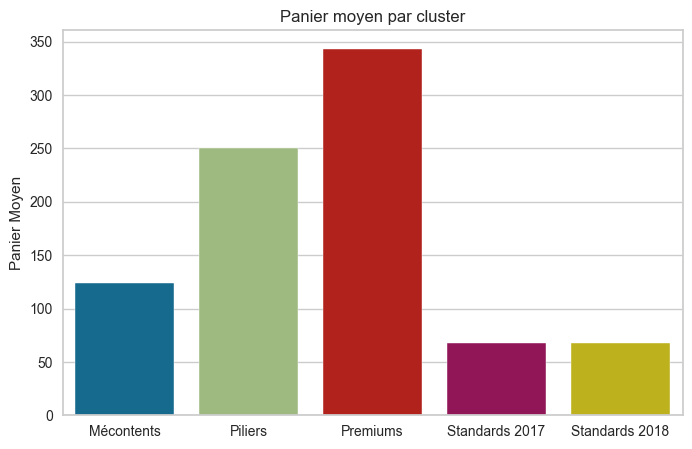

                Panier Moyen
cluster                     
Mécontents        124.330187
Piliers           250.753667
Premiums          343.458608
Standards 2017     68.121700
Standards 2018     67.656375


In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=customers_rfm.groupby('cluster')['Panier Moyen'].mean().index, y=customers_rfm.groupby('cluster')['Panier Moyen'].mean())
plt.title('Panier moyen par cluster')
plt.xlabel('') 
plt.show()

print(customers_rfm.groupby('cluster').agg({'Panier Moyen': 'mean'}))

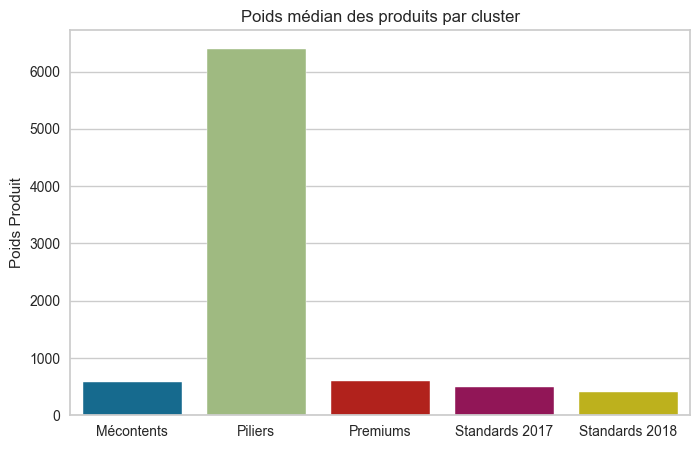

In [ ]:

plt.figure(figsize=(8, 5))
sns.barplot(x=customers_rfm.groupby('cluster')['Poids Produit'].median().index, y=customers_rfm.groupby('cluster')['Poids Produit'].median())
plt.title('Poids médian des produits par cluster')
plt.xlabel('') 
plt.show()

Text(0.5, 1.0, 'Score moyen par cluster')

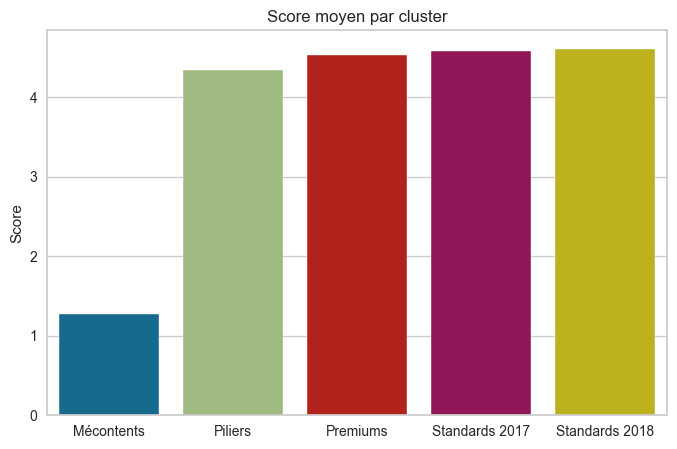

In [ ]:

plt.figure(figsize=(8, 5))
sns.barplot(x=customers_rfm.groupby('cluster')['Score'].mean().index, y=customers_rfm.groupby('cluster')['Score'].mean())
plt.xlabel('') 
plt.title('Score moyen par cluster')

In [ ]:
# Filtrer d'abord les clients avec une fréquence > 1
filtered_customers = customers_rfm[customers_rfm['cluster'] == 'Piliers']

filtered_customers_3 = filtered_customers[filtered_customers['Fréquence'] > 1]


# Ensuite, calculer le nombre de ces clients dans chaque cluster
cluster_counts = filtered_customers_3['cluster'].value_counts()
# Calculer le pourcentage de ces clients dans l'ensemble du DataFrame
percentage = (cluster_counts / filtered_customers.shape[0]) * 100
percentage

cluster
Piliers    2.971455
Name: count, dtype: float64

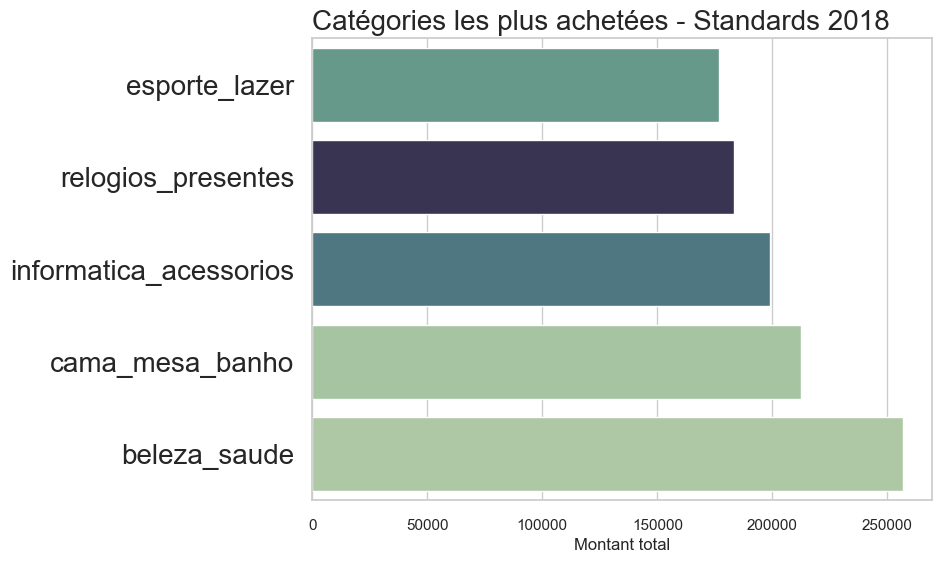

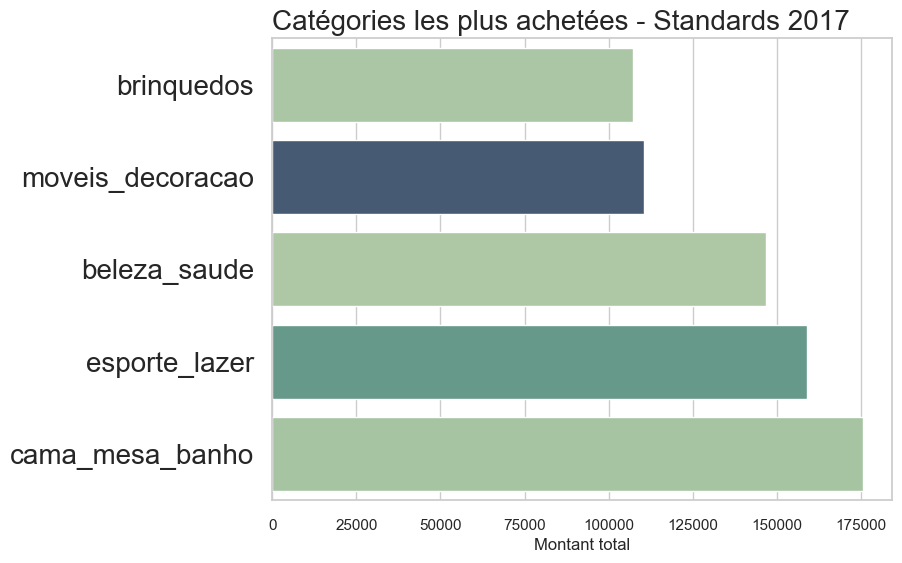

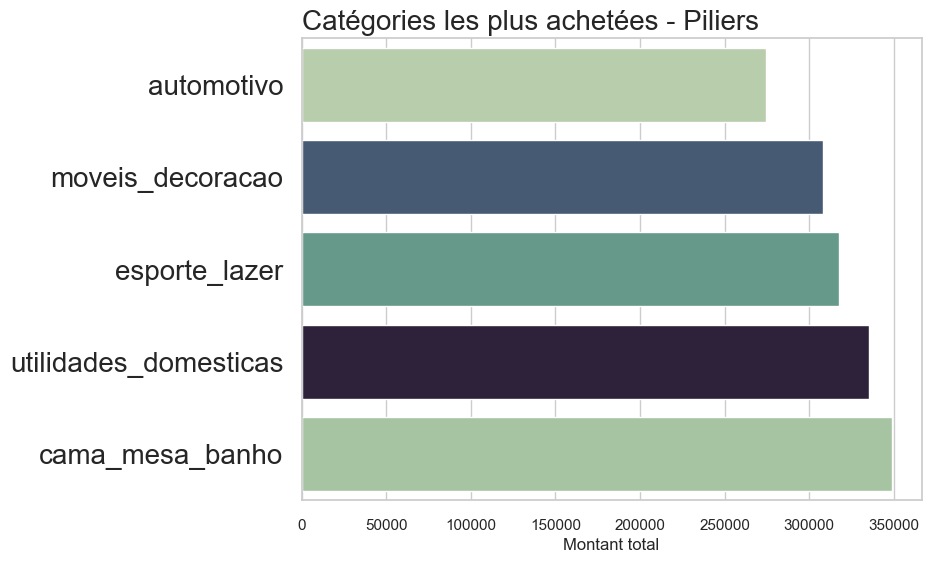

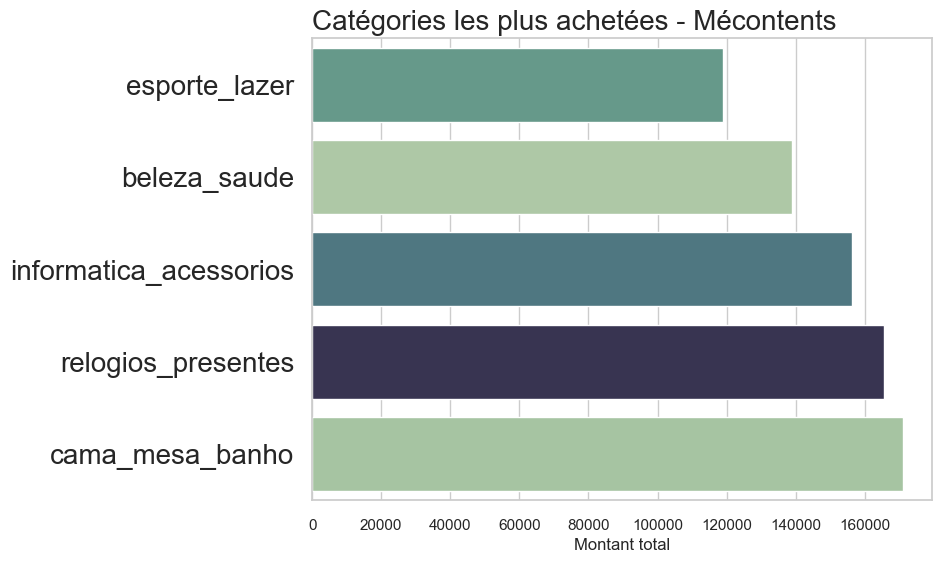

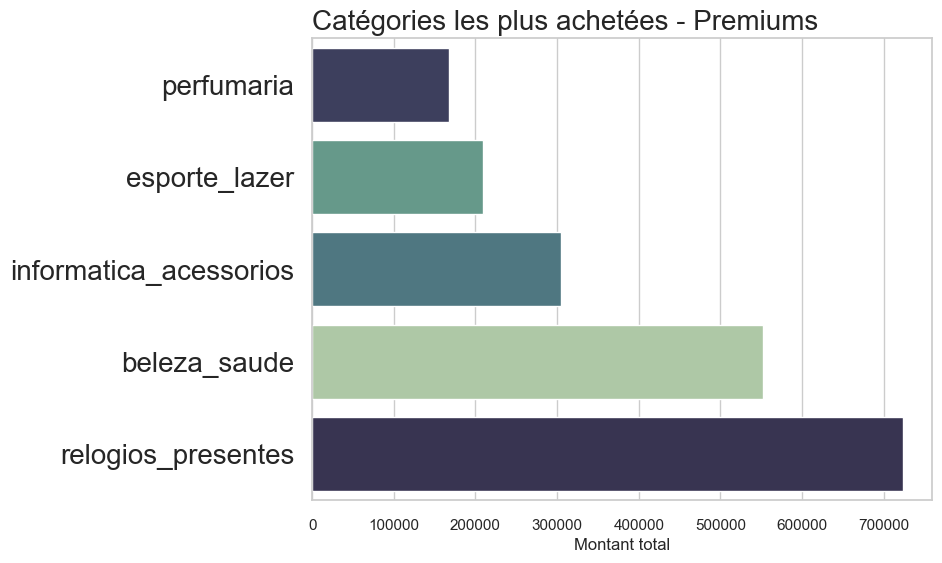

In [ ]:
# Assurez-vous que 'customers_rfm' est le DataFrame correct contenant les données nécessaires
# Créer une palette de couleurs étendue pour les catégories de produits
categories = customers_rfm['Catégorie Produit'].astype(str).unique()
categories = np.sort(categories)

# Utiliser une palette "cubehelix" qui offre une bonne variation de couleurs
colors = sns.cubehelix_palette(len(categories), start=.5, rot=-.75)
color_dict = {category: color for category, color in zip(categories, colors)}
default_color = '#e8e8e8'  # Gris clair, utilisé comme couleur par défaut

# Pour chaque cluster
for cluster in customers_rfm['cluster'].unique():
    # Calculer le montant total par catégorie de produit pour ce cluster
    data = customers_rfm[customers_rfm['cluster'] == cluster].groupby('Catégorie Produit')['Montant_total'].sum().sort_values(ascending=False).head(5)

    # Créer le graphique
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))  # Ajuster la taille pour une meilleure visibilité

    # Définir les couleurs pour chaque barre
    bar_colors = [color_dict.get(cat, default_color) for cat in data.index]

    # Dessiner le graphique en barres
    sns.barplot(x=data.values, y=data.index, palette=bar_colors)

    # Configurer le titre et les étiquettes des axes
    plt.title(f'Catégories les plus achetées - {cluster}', fontsize=20, loc='left')
    plt.xlabel('Montant total')
    plt.ylabel('')
    plt.yticks(fontsize=20)

    # Inverser l'axe y pour afficher la catégorie avec le montant le plus élevé en haut
    plt.gca().invert_yaxis()

    # Afficher le graphique
    plt.show()


In [ ]:

dtime = customers_rfm.copy()
# Assurez-vous que 'order_purchase_timestamp' est une datetime
dtime['order_purchase_timestamp'] = pd.to_datetime(dtime['order_purchase_timestamp'])

# Filtrer les données entre '2017-01-01' et '2018-08-31'
dtime = dtime[(dtime['order_purchase_timestamp'] >= '2017-01-01') & (dtime['order_purchase_timestamp'] <= '2018-08-31')]

# Regrouper par mois et par cluster, puis calculer la somme du 'Montant_total'
dtime_grouped = dtime.groupby([pd.Grouper(key='order_purchase_timestamp', freq='M'), 'cluster'])['Montant_total'].sum().reset_index()

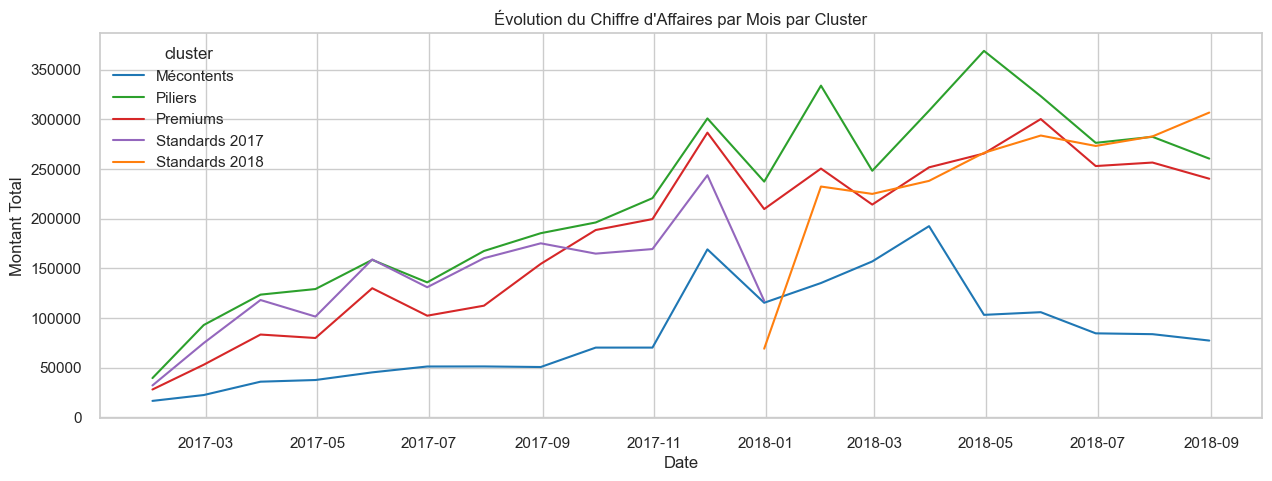

In [ ]:

# Couleurs identifiées à partir des graphiques existants
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e'] # Remplacez ces codes hexadécimaux par les vôtres

plt.figure(figsize=(15, 5))
sns.lineplot(x='order_purchase_timestamp', y='Montant_total', hue='cluster', data=dtime_grouped, palette=colors)
plt.title('Évolution du Chiffre d\'Affaires par Mois par Cluster')
plt.xlabel('Date')
plt.ylabel('Montant Total')
plt.show()